<a href="https://colab.research.google.com/github/frapasti/Embedded-Person-detection/blob/main/Stat_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiftyone --no-binary fiftyone,voxel51-eta
import fiftyone as fo
import fiftyone.zoo as foz
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import json
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import cv2
import imutils
from google.colab.patches import cv2_imshow

Import a dataset of images containing persons from the coco test split

In [4]:
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person"],
    only_matching = True,
    max_samples=500,
)

 100% |██████|    1.9Gb/1.9Gb [2.5s elapsed, 0s remaining, 743.3Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'
 100% |██████████████████| 500/500 [46.0s elapsed, 0s remaining, 11.3 images/s]      
Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'validation'
 100% |█████████████████| 500/500 [2.6s elapsed, 0s remaining, 203.9 samples/s]      
Dataset 'coco-2017-validation-500' created


# **DATA ORGANIZATION**

  Now extract the paths of the images that have been downloaded and save them in a list called "**every_path**"

  For each image count the number of persons that are present and return the number in the list "**counters**"

  For each image append the ground truth boxes in the list "**bboxes**"


In [50]:
f = open('/root/fiftyone/coco-2017/validation/labels.json')
data = json.load(f)
annotations = data['annotations']
every_path = []
cols = 10
rows = 500
bbox_size = 4
counters = [0] * rows
bboxes = [[] for i in range(rows)] 
items = 0
#creation of the list of paths of images in the dataset
for entry in data['annotations']:
    class_id = entry['category_id']
    if (class_id == 1):
        img_id = entry['image_id']
        path = float(img_id)/pow(10,11)
        dec_path = format(path, '.11f')
        final_path = ''
        final_path = '/root/fiftyone/coco-2017/validation/data/'+ dec_path.replace('.', '') + '.jpg'
        if(every_path.count(final_path) == 0):
          every_path.append(final_path)
          bboxes[items].append(entry['bbox'])
          items = items + 1
        else:
          index = every_path.index(final_path)
          if(counters[index] + 1 < 10):
            bboxes[index].append(entry['bbox'])
            counters[index] = counters[index] + 1
every_img = []
for i in range(0, rows):
    image = load_img(every_path[i], target_size=(416, 416))
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0
    image = expand_dims(image, 0)
    every_img.append(image)

Function to calculate the Intersection Over Union of a ground box and a predicted box

In [23]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox[0] , gt_bbox[1], gt_bbox[0] + gt_bbox[2] , gt_bbox[1] + gt_bbox[3]
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox[0] , pred_bbox[1], pred_bbox[0] + pred_bbox[2] , pred_bbox[1] + pred_bbox[3]
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

# **HOG EVALUATION**

Exploiting the hog detector provided by OpenCV, this detector returns a list of proposed boxes for an image

In [33]:
def hog_detector(im_path): 
  # Initializing the HOG person
  # detector
  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    
  # Reading the Image
  image = cv2.imread(im_path)
    
  # Resizing the Image
  image = imutils.resize(image,
                        width=min(400, image.shape[1]))
    
  # Detecting all the regions in the 
  # Image that has a pedestrians inside it
  (regions, _) = hog.detectMultiScale(image, 
                                      winStride=(4, 4),
                                      padding=(4, 4),
                                      scale=1.05)
    
  # Drawing the regions in the Image
  for (x, y, w, h) in regions:
      cv2.rectangle(image, (x, y), 
                    (x + w, y + h), 
                    (0, 0, 255), 2)
    
  # Showing the output Image
  cv2_imshow(image)

  return regions

Now for each image in our dataset we calculate the regions proposed by Hog and save them in the list **prop_regions**

In [19]:
prop_regions = []
for i in range(0,500):
  prop_regions.append(hog_detector(every_path[i]))

Finally calcualte the detection rate based on an IOU_threshold, if the IoU threshold is small then more boxes will be considered as correct predictions.

The number of correct predictions will then be compared with the number of supposed predictions, so the number of persons that are supposed to be in the image

The script calculates the detection rate as person detected / total person based on different iou_thresholds

In [68]:
iou_thr = 0
iou_thresholds = []
detection_rate_iou = []
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  detection_rate = [0]*500
  for i in range(0,500):
    for j in prop_regions[i]:
      for h in bboxes[i]:
        if (calc_iou(h,j) > iou_thr):
          if(detection_rate[i] < len(bboxes[i])):
            detection_rate[i] += 1;
    detection_rate[i] = detection_rate[i]/len(bboxes[i])
  temp = sum(detection_rate)/500
  detection_rate_iou.append(temp)

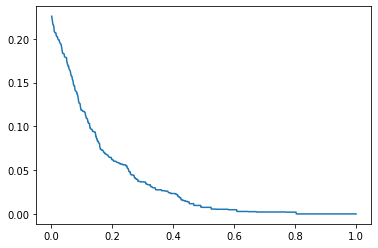

In [69]:
pyplot.plot(iou_thresholds, detection_rate_iou)
pyplot.show()

# **VIOLA AND JONES**

Now do the same type of evaluation for the Viola and Jones method provided by OpenCV

In [78]:
def viola_detector(im_path): 
    
  #Reading the Image
  image = cv2.imread(im_path)

  #convert in gray_scale since the cascade classifier works on gray_scale images
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #load the cascade classifier, detect the bodies in the image and draw them for the user to see
  body_cascade = cv2.CascadeClassifier('/haarcascade_fullbody.xml')
  detected_bodies = body_cascade.detectMultiScale(grayscale_image)
  for (column, row, width, height) in detected_bodies:
      cv2.rectangle(image,(column, row),(column + width, row + height),(0, 255, 0),4)    
  #Showing the output Image
  #cv2_imshow(image)

  return detected_bodies

In [82]:
prop_regions_viola = []
for i in range(0,500):
  prop_regions_viola.append(viola_detector(every_path[i]))

In [85]:
iou_thr = 0
iou_thresholds = []
detection_rate_iou_viola = []
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  detection_rate = [0]*500
  for i in range(0,500):
    for j in prop_regions_viola[i]:
      for h in bboxes[i]:
        if (calc_iou(h,j) > iou_thr):
          if(detection_rate[i] < len(bboxes[i])):
            detection_rate[i] += 1;
    detection_rate[i] = detection_rate[i]/len(bboxes[i])
  temp = sum(detection_rate)/500
  detection_rate_iou_viola.append(temp)

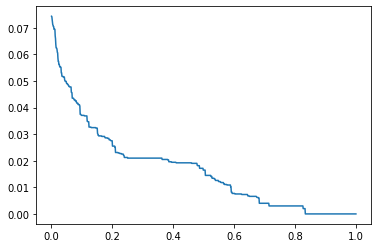

In [86]:
pyplot.plot(iou_thresholds, detection_rate_iou_viola)
pyplot.show()

# **Improving Viola**

The same type of test have been done on the Viola and Jones detector and it's clear that it performs much worse, a reason could be that the cascade classifier is only for full bodies, a way to improve this performance could be to also use the haarcascade upper body and haar cascade lower body and see if it works better

In [105]:
def viola_detector_powered(im_path): 
    
  #Reading the Image
  image = cv2.imread(im_path)

  #convert in gray_scale since the cascade classifier works on gray_scale images
  grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  #load the cascade classifier, detect the bodies in the image and draw them for the user to see
  body_cascade = cv2.CascadeClassifier('/haarcascade_fullbody.xml')
  lbody_cascade = cv2.CascadeClassifier('/haarcascade_lowerbody.xml') #lower body
  ubody_cascade = cv2.CascadeClassifier('/haarcascade_upperbody.xml') #upper body
  
  detected_bodies = body_cascade.detectMultiScale(grayscale_image)
  ldetected_bodies = lbody_cascade.detectMultiScale(grayscale_image) #lower_body
  udetected_bodies = ubody_cascade.detectMultiScale(grayscale_image) #upper_body
  
  tot_bodies = list(detected_bodies) + list(ldetected_bodies) + list(udetected_bodies) #concatenate all the detected bboxes

  for (column, row, width, height) in tot_bodies:
      cv2.rectangle(image,(column, row),(column + width, row + height),(0, 255, 0),4)    
  #Showing the output Image
  #cv2_imshow(image)

  return tot_bodies

In [106]:
prop_regions_viola_powered = []
for i in range(0,500):
  prop_regions_viola_powered.append(viola_detector_powered(every_path[i]))

In [109]:
iou_thr = 0
iou_thresholds = []
detection_rate_iou_viola_powered = []
for h in range(0,1000):
  iou_thr += 0.001  
  iou_thresholds.append(iou_thr)
  detection_rate = [0]*500
  for i in range(0,500):
    for j in prop_regions_viola_powered[i]:
      for h in bboxes[i]:
        if (calc_iou(h,j) > iou_thr):
          if(detection_rate[i] < len(bboxes[i])):
            detection_rate[i] += 1;
    detection_rate[i] = detection_rate[i]/len(bboxes[i])
  temp = sum(detection_rate)/500
  detection_rate_iou_viola_powered.append(temp)

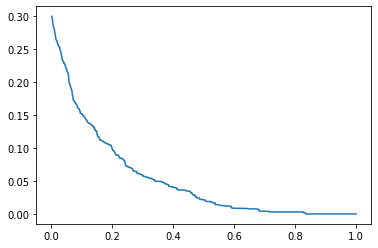

In [112]:
pyplot.plot(iou_thresholds, detection_rate_iou_viola_powered)
pyplot.show()

Now it performs much better! However using all this classifier could sensibly decrease the performances

# **TINY YOLO v3**

Do the same type of evaluations on the tiny_yolo_v3 dataset

In [120]:
!git clone https://github.com/pjreddie/darknet
%cd darknet
!make

fatal: destination path 'darknet' already exists and is not an empty directory.
/content/darknet
mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-un

In [121]:
!wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2022-06-16 10:48:06--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M  27.4MB/s    in 1.2s    

2022-06-16 10:48:08 (27.4 MB/s) - ‘yolov3-tiny.weights’ saved [35434956/35434956]

